In [1]:
import numpy as np
from collections import defaultdict
import os

In [2]:
class Partition:
    def __init__(self, id):
        self.id = id
        self.n_nodes = 0
        self.n_edges = 0
        self.n_masters = 0
        self.n_rep_edges = 0
        self.edges = []
        self.nodes = []
        self.masters = []
        self.mirrors = []
        self.rep_edges = []

    def save_result(self, path, function=''):
        with open(path, 'a') as file:
            if function == 'edge':
                file.write(f'Partition {self.id}\n')
                file.write(f'{len(self.masters)}\n')
                file.write(f'{len(self.masters) + len(self.mirrors)}\n')
                file.write(f'{len(self.rep_edges)}\n{len(self.edges) + len(self.rep_edges)}\n')
            if function == 'vertex':
                file.write(f'Partition {self.id}\n')
                file.write(f'{len(self.masters)}\n')
                file.write(f'{len(self.nodes)}\n{len(self.edges)}\n')
            if function == 'hybrid':
                file.write(f'Partition {self.id}\n')
                file.write(f'{len(self.masters)}\n')
                file.write(f'{len(self.nodes)}\n')
                file.write(f'{len(self.edges)}\n')

In [3]:
def delete_duplicates(l):
    s = set()
    n = 0
    for i in l:
        if i not in s: 
            s.add(i)
            l[n] = i
            n += 1
    del l[n:]
    return l

In [4]:
def edge_cut(graph, n, directed=False):
    partitions = [Partition(id) for id in range(n)]
    
    for edge in graph.edges:
            src_partition = edge[0] % n
            dst_partition = edge[1] % n

            #undirected, count edge twice
            partitions[src_partition].masters.append(edge[0])

            # directed, add node to master partition
            if directed:
                partitions[dst_partition].masters.append(edge[1])

            # create mirror in other edge also replicated edge
            if src_partition != dst_partition:
                partitions[src_partition].mirrors.append(edge[1])
                partitions[dst_partition].mirrors.append(edge[0])

                partitions[src_partition].rep_edges.append(edge)

                if directed:
                    partitions[dst_partition].rep_edges.append(edge)

            elif src_partition == dst_partition:
                partitions[src_partition].masters.append(edge[1])
                partitions[src_partition].edges.append(edge)

    for p in partitions:
        p.masters = delete_duplicates(p.masters)
        p.mirrors = delete_duplicates(p.mirrors)
        p.edges = delete_duplicates(p.edges)
        p.rep_edges = delete_duplicates(p.rep_edges)

    return partitions

In [5]:
def vertex_cut(graph, n, directed=False, flying_master=True):
    partitions = [Partition(id) for id in range(n)]
    node_owner = defaultdict(set)

    for edge in graph.edges:
        
        partition_id = hash(edge) % n # partition_id as hash of the edge

        # if undirected, pass duplicated edge
        if not directed and edge[0] > edge[1]:
            continue
        partitions[partition_id].edges.append(edge)

        node_owner[edge[0]].add(partition_id)
        node_owner[edge[1]].add(partition_id)

        partitions[partition_id].nodes.append(edge[0])
        partitions[partition_id].nodes.append(edge[1])
    
    for node in node_owner.keys():
        if flying_master:
            id = node % n
        else:
            pos = (node % n) % len(node_owner[node])
            id = list(node_owner)[node][pos]

        partitions[id].masters.append(node)

    for p in partitions:
        p.nodes = delete_duplicates(p.nodes)
        
    return partitions

In [6]:
def greedy_vertex_cut(graph, n):
    partitions = [Partition(id) for id in range(n)]
    node_owner = defaultdict(set)
    num_edges_in_node = defaultdict(int)

    for edge in graph.edges:
        num_of_servers = set()

        if node_owner[edge[0]].intersection(node_owner[edge[1]]):
            num_of_servers = node_owner[edge[0]].intersection(node_owner[edge[1]])
            
            partition_id = np.random.choice(tuple(num_of_servers))
            partitions[partition_id].edges.append(edge)

        
        elif node_owner[edge[0]] and node_owner[edge[1]] and not node_owner[edge[0]].intersection(node_owner[edge[1]]):
            num_of_servers = node_owner[edge[0]] if num_edges_in_node[edge[0]] <= num_edges_in_node[edge[1]] else node_owner[edge[1]]
           #select
            partition_id = np.random.choice(tuple(num_of_servers))
            partitions[partition_id].edges.append(edge)
            partitions[partition_id].nodes.append(edge[0])
            partitions[partition_id].nodes.append(edge[1])

            node_owner[edge[0]].add(partition_id)
            node_owner[edge[1]].add(partition_id)

        elif (node_owner[edge[0]] and not node_owner[edge[1]]) or (not node_owner[edge[0]] and node_owner[edge[1]]):
            if node_owner[edge[0]]:
                num_of_servers = node_owner[edge[0]]
            else:
                num_of_servers = node_owner[edge[1]]
            partition_id = np.random.choice(tuple(num_of_servers))
            if node_owner[edge[0]]:
                partitions[partition_id].masters.append(edge[1])
            else:
                partitions[partition_id].masters.append(edge[0])
            partitions[partition_id].edges.append(edge)
            partitions[partition_id].nodes.append(edge[0])
            partitions[partition_id].nodes.append(edge[1])
            node_owner[edge[0]].add(partition_id)
            node_owner[edge[1]].add(partition_id)

        # vertex not assigned?, the edge should go to the less busy server
        else:
            for p in partitions:
                if len(p.nodes) == min([len(p.nodes) for p in partitions]):
                    partition_id = p.id
                    break
            partitions[partition_id].edges.append(edge)
            partitions[partition_id].nodes.append(edge[0])
            partitions[partition_id].nodes.append(edge[1])
            partitions[partition_id].masters.append(edge[0])
            partitions[partition_id].masters.append(edge[1])
            node_owner[edge[0]].add(partition_id)
            node_owner[edge[1]].add(partition_id)

        num_edges_in_node[edge[0]] += 1
        num_edges_in_node[edge[1]] += 1

    for p in partitions:
        p.nodes = delete_duplicates(p.nodes)
        p.edges = delete_duplicates(p.edges)

    return partitions

In [7]:
def hybrid_cut(graph, n, directed=False, threshold = 50):
    starting_time = time.time()
    partitions = [Partition(id) for id in range(n)]
    node_indegree = defaultdict(int)

    for edge in graph.edges:

        u = edge[0]
        v = edge[1]

        # if undirected, skip duplicated edge
        if not directed and u < v:
            node_indegree[v] += 1

        if node_indegree[v] <= threshold:
            partition_id = v % n
            partitions[partition_id].masters.append(v)
            partitions[partition_id].nodes.append(v)
            partitions[partition_id].edges.append(edge)
        else:
            partition_id = u % n
            partitions[partition_id].edges.append(edge)

    # add mirror nodes
    for p in partitions:
        for e in p.edges:
            u = e[0]
            p.nodes.append(u)

    for p in partitions:
        p.nodes = delete_duplicates(p.masters)
        p.nodes = delete_duplicates(p.nodes)
        p.edges = delete_duplicates(p.edges)
    ending_time = time.time()
    print(f'time: {ending_time - starting_time}')
        
    return partitions

In [8]:
class Graph:
    def __init__(self):
        self.vertices = set()
        self.edges = set()

    def set_graph(self, vertices, edges):
        self.vertices = vertices
        self.edges = edges

    def add_edge(self, edge):
        self.edges.add(edge)
        self.vertices.add(edge[0])
        self.vertices.add(edge[1])

    def add_vertex(self, vertex):
        self.vertices.add(vertex)

    def edges(self):
        return self.edges
        
    def vertices(self):
        return self.vertices
        
def load_binary_graph(file_name):
    with open(file_name, "rb") as file:
        graph = Graph()
        while True:
            source = file.read(4)
            dest = file.read(4)

            if not source:
                break

            source = int.from_bytes(source, byteorder='little')
            dest = int.from_bytes(dest, byteorder='little')

            graph.add_edge((source, dest))

        return graph

Note: Repeting edges are represented as red


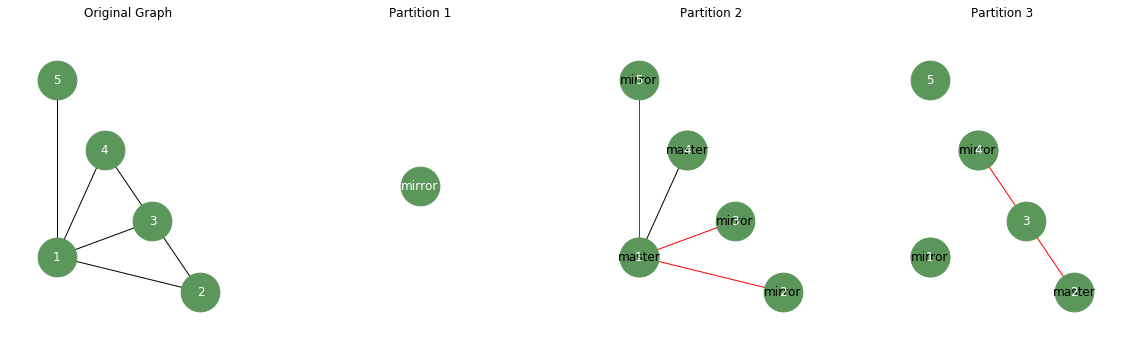

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

graph = load_binary_graph('small-5.graph')
partitions = edge_cut(graph, 3, directed=False)
G=nx.Graph()

for edge in graph.edges:
    G.add_edge(edge[0], edge[1])
    
pos = {1: [0.1, 0.25],
       2: [0.4, 0.2],
       3: [0.3, 0.3],
       4: [0.2, 0.4],
       5: [0.1, 0.5]}

print("Note: Repeting edges are represented as red")
fig = plt.figure(figsize=(20,6))
plt.subplot(1, 4, 1)
nx.draw(G, pos=pos, with_labels=True, node_size=1500, node_color='#5b965b', font_size=12, font_color='white')
plt.title('Original Graph')

plt.subplot(1, 4, 2)
nx.draw(G, pos=pos, with_labels=True, nodelist=[1], edgelist=[], node_size=1500, node_color='#5b965b', font_size=12, font_color='white', labels={1:'mirror'})
plt.title('Partition 1')

plt.subplot(1, 4, 3)
nx.draw(G, pos=pos, with_labels=True, nodelist=[1,2,3,4,5], edgelist=[(1, 4)], node_size=1500, node_color='#5b965b', font_size=12, edge_color='black', 
                                                                                                    labels={1:'master',
                                                                                                          2: 'mirror',
                                                                                                          3: 'mirror',
                                                                                                          4: 'master',
                                                                                                          5: 'mirror'})
nx.draw(G, pos=pos, with_labels=True, nodelist=[1, 4], edgelist=[(1, 2), (1, 3), (1, 5)], node_size=1500, node_color='#5b965b', font_size=12, font_color='white', edge_color='red')
plt.title('Partition 2')

plt.subplot(1, 4, 4)
nx.draw(G, pos=pos, with_labels=True, nodelist=[1,2,3,4,5], edgelist=[], edge_color='black', node_size=1500, node_color='#5b965b', font_size=12,
                                                                                                    labels={1:'mirror',
                                                                                                           2: 'master',
                                                                                                          4: 'mirror'})
nx.draw(G, pos=pos, with_labels=True, nodelist=[1, 4], edgelist=[(2, 4)], node_size=1500, node_color='#5b965b', font_size=12, font_color='white', edge_color='red')
plt.title('Partition 3')

plt.show()
fig.savefig('graph.png')

In [14]:
# In order to get the output texts you have to make sure that the directory locations are called correctly.

In [15]:
# if __name__ == '__main__':
#     file_names = [('small-5.graph', False), ('roadNet-PA.graph', False)]
    
#     for file_name in file_names:
#         dirname = 'output_' + file_name[0][:-6]
#         if not os.path.exists(dirname):
#             os.mkdir(dirname)
#         graph = load_binary_graph('/data/hw8/' + file_name[0])
#         for i in [2, 3, 4, 8]:
#             partitions = edge_cut(graph, i, directed=file_name[1])
#             save_to = '.' + os.path.sep + dirname + os.path.sep + file_name[0][:-6] + '_e-cut_' + str(i) + '.txt'

#             for p in partitions:
#                 p.save_result(save_to, function='edge')
                
#         for i in [2, 3, 4, 8]:
#             partitions = vertex_cut(graph, i, directed=file_name[1])
#             save_to = '.' + os.path.sep + dirname + os.path.sep + file_name[0][:-6] + '_v-cut_' + str(i) + '.txt'

#             for p in partitions:
#                 p.save_result(save_to, function='vertex')
            
#         for i in [2, 3, 4, 8]:
#             partitions = greedy_vertex_cut(graph, i)
#             save_to = '.' + os.path.sep + dirname + os.path.sep +  file_name[0][:-6] + '_greedy-v-cut_' + str(i) + '.txt'

#             for p in partitions:
#                 p.save_result(save_to, function='vertex')
                
#         for i in [2, 3, 4, 8]:
#             partitions = hybrid_cut(graph, i, directed=file_name[1])
#             save_to = '.' + os.path.sep + dirname + os.path.sep + file_name[0][:-6] + '_hybrid-cut_' + str(i) + '.txt'

#             for p in partitions:
#                 p.save_result(save_to, function='hybrid')